Final Submission notebook for GS Quantify 2019

The problem is identified as clustering

### Import

In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('/content/drive/My Drive/GS_Quantify_2019/data/train_set.txt',sep='delimiter', header=None)
data_test_public = pd.read_csv('/content/drive/My Drive/GS_Quantify_2019/data/public_test_set.txt',sep='delimiter', header=None)
data_test_private = pd.read_csv('/content/drive/My Drive/GS_Quantify_2019/data/private_test_set.txt',sep='delimiter', header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel 

### TF-IDF approach

Separate all the words, doesnt matter how many words are there, just use all the delimeters and separate

1. Spaces
2. Dots
3. Commas
4. Hyphens (maybe)

Then use all the standard preprocessing techniques

In [0]:
import re 
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#### Preprocessing

In [0]:
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [0]:
def preprocess(data):
    import re 
    from textblob import Word
    import nltk

    data = data[0].apply(lambda x:[i.split('.')for i in x.strip().split()])

#     data = data.apply(lambda x:[remove(i) for i in x])
    
    data = data.apply(lambda x:' '.join(j for i in x for j in i ))
    data = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data =  data.str.replace('[^\w\s]','')

    remove_word = ['gs','lgs','log','info','_','__']

    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in remove_word))

    
    # nltk.download('wordnet')
    data = data.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    data = data.apply(lambda x:x.strip(x.split()[0]))
    
    return data

In [0]:
train = preprocess(data)

In [0]:
test_public = preprocess(data_test_public)

In [0]:
test_private = preprocess(data_test_private)

### Word2Vec

After experimenting a lot with TF-IDF approach, we will try the word2vec pretrained embedsdings

In [0]:
import gensim
import logging

These embeddings need to be downloaded in your local machine, and then can be loaded to transform your document into numeric data

In [0]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/Hate_Speech_Detection_git/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We use the averaging method here, basically converting all the words in a sentence into a vector and then taking mean of all the vectors in a sentence, which will represent that sentence in a N-Dimensional numeric vector.

We use Google-News pretrained word embeddings for training, it can be downloaded from [here](https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz)

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [0]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


import nltk
nltk.download('punkt')

train_w2v, test_w2v, test_private_w2v = train, test_public, test_private

test_tokenized_private = test_private_w2v.apply(lambda r: w2v_tokenize_text(r)).values

test_tokenized = test_w2v.apply(lambda r: w2v_tokenize_text(r)).values

train_tokenized = train_w2v.apply(lambda r: w2v_tokenize_text(r)).values



X_train_word_average = word_averaging_list(wv,train_tokenized)

X_test_word_average = word_averaging_list(wv,test_tokenized)

X_test_private_word_average = word_averaging_list(wv,test_tokenized_private)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Model after FE

We do a little bit of Feature engineering here, we concat the PCA components of data to current feature matrix. This gave a significant increament on leaderboard

In [0]:
x_t = X_train_word_average
x_v = X_test_word_average
x_v_private = X_test_private_word_average
## these were the feature matrices we used before PCA Fature engineering


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pca_x = np.concatenate([x_t,pca.fit_transform(X_train_word_average)],axis=1)
pca_x_v = np.concatenate([x_v,pca.transform(X_test_word_average)],axis=1)
pca_x_v_private =  np.concatenate([x_v_private,pca.transform(X_test_private_word_average)],axis=1)
# X = pca.fit_transform(x_t_df)

### Final Model

#### K-Means Clustering

In [0]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,max_iter=150)
# km.fit(x_t)
km.fit(pca_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# km.predict(x_t)
km.predict(pca_x)
labels = km.labels_

In [0]:
km.inertia_

8180.185262008089

##### Lets save this model, for reproducibility of our results

In [0]:
# import pickle
# filename = 'best_model_9_40pm_latest_954.sav'
# pickle.dump(km, open(filename, 'wb'))

### Lets visualize this

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

X = pca.fit_transform(x_t)
# X = pca.fit_transform(x_t_df)

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Text(0.5, 0.92, 'K Means')

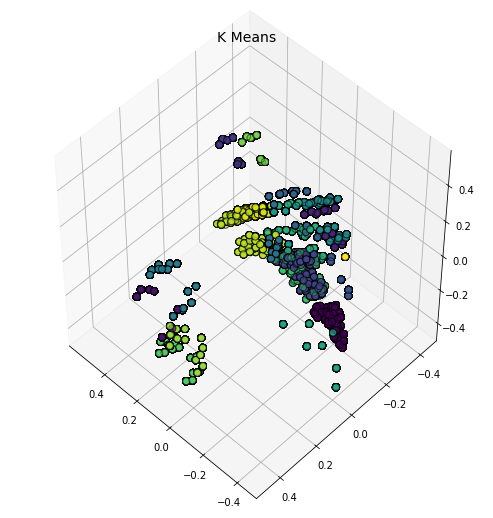

In [0]:
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter3D(X[:, 2], X[:, 0], X[:, 1],
          c=labels.astype(np.float), edgecolor="k", s=50)
plt.title("K Means", fontsize=14)

#### We do see some clusters, lets predict on test data

### Submission

In [0]:
# import pickle
# loaded_model = pickle.load(open('best_model_asofnow.sav', 'rb'))
# subs = pd.Series(loaded_model.predict(x_v))

In [0]:
# subs = pd.Series(km.predict(x_v))
subs = pd.Series(km.predict(pca_x_v))
subs = subs.apply(lambda x:'C'+str(x+1))
line_no = pd.Series(range(0,len(test_public))).apply(lambda x:'L'+str(x))
submission = pd.DataFrame(line_no,columns=['LineNumber'])
submission['Class'] = subs

In [0]:
submission['Class'] = subs

In [0]:
submission.to_csv('submission_3_clusters#20_word2vec_pca_add.csv',index=False, header=True)

### Private Set

In [0]:
# subs_private = pd.Series(loaded_model.predict(x_v_private))

subs_private = pd.Series(km.predict(pca_x_v_private))

subs_private = subs_private.apply(lambda x:'C'+str(x+1))
line_no = pd.Series(range(0,len(test_private))).apply(lambda x:'L'+str(x))
submission_private = pd.DataFrame(line_no,columns=['LineNumber'])
submission_private['Class'] = subs_private

In [0]:
submission_private.to_csv('submission_3_clusters_word2vec_pca_add_PRIVATE.csv',index=False, header=True)

#### PRIVATE submission done!

### Elbow Method - Execute these cells for param tuning

#### Current optimal params - 
1. k = 20
2. max_iter = 150

In [0]:
# from sklearn import metrics 
# from scipy.spatial.distance import cdist 

In [0]:
# x=x_t.todense()

In [0]:
# distortions = [] 
# inertias = [] 
# mapping1 = {} 
# mapping2 = {} 
# K = range(5,20) 
  
# x = x_t.todense()

# count=0
# for k in K: 
#     #Building and fitting the model 
#     kmeanModel = KMeans(n_clusters=k).fit(x) 
#     kmeanModel.fit(x)     
      
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 
#                       'euclidean'),axis=1)) / x.shape[0]) 
#     inertias.append(kmeanModel.inertia_) 
  
#     mapping1[k] = sum(np.min(cdist(x, kmeanModel.cluster_centers_, 
#                  'euclidean'),axis=1)) / x.shape[0] 
#     mapping2[k] = kmeanModel.inertia_ 
    
#     count+=1
#     print(count,'Models trained ..')

In [0]:
# for key,val in mapping1.items(): 
#     print(str(key)+' : '+str(val)) 

# plt.plot(iters, distortions, 'bx-') 
# plt.xlabel('Values of K') 
# plt.ylabel('Distortion') 
# plt.title('The Elbow Method using Distortion') 
# plt.show() 

In [0]:
# for key,val in mapping2.items(): 
#     print(str(key)+' : '+str(val))
    
# plt.plot(iters, inertias, 'bx-') 
# plt.xlabel('Values of K') 
# plt.ylabel('Inertia') 
# plt.title('The Elbow Method using Inertia') 
# plt.show() 